In [1]:
from google.colab import files
uploaded = files.upload()

Saving soil_data_incl_rain_v3.csv to soil_data_incl_rain_v3.csv


Saving soil_data_incl_rain_v3.csv to soil_data_incl_rain_v3 (1).csv
Original shape: (8761, 6)
Daily data: 366 days
Train: (251, 7, 4), Test: (108, 7, 4)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 64)          │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,801 (206.25 KB)

 Trainable params: 52,801 (206.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - loss: 0.1485 - val_loss: 0.0451
Epoch 2/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0530 - val_loss: 0.0431
Epoch 3/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0402 - val_loss: 0.0491
Epoch 4/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0406 - val_loss: 0.0423
Epoch 5/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0353 - val_loss: 0.0431
Epoch 6/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0406 - val_loss: 0.0432
Epoch 7/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0405 - val_loss: 0.0428
Epoch 8/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0373 - val_loss: 0.0437
Epoch 9/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0352 - val_loss: 0.0423
Epoch 10/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0428 - val_loss: 0.0425
Epoch 11/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0387 - val_loss: 0.0438
Epoch 12/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0413 - val_loss: 0.0421


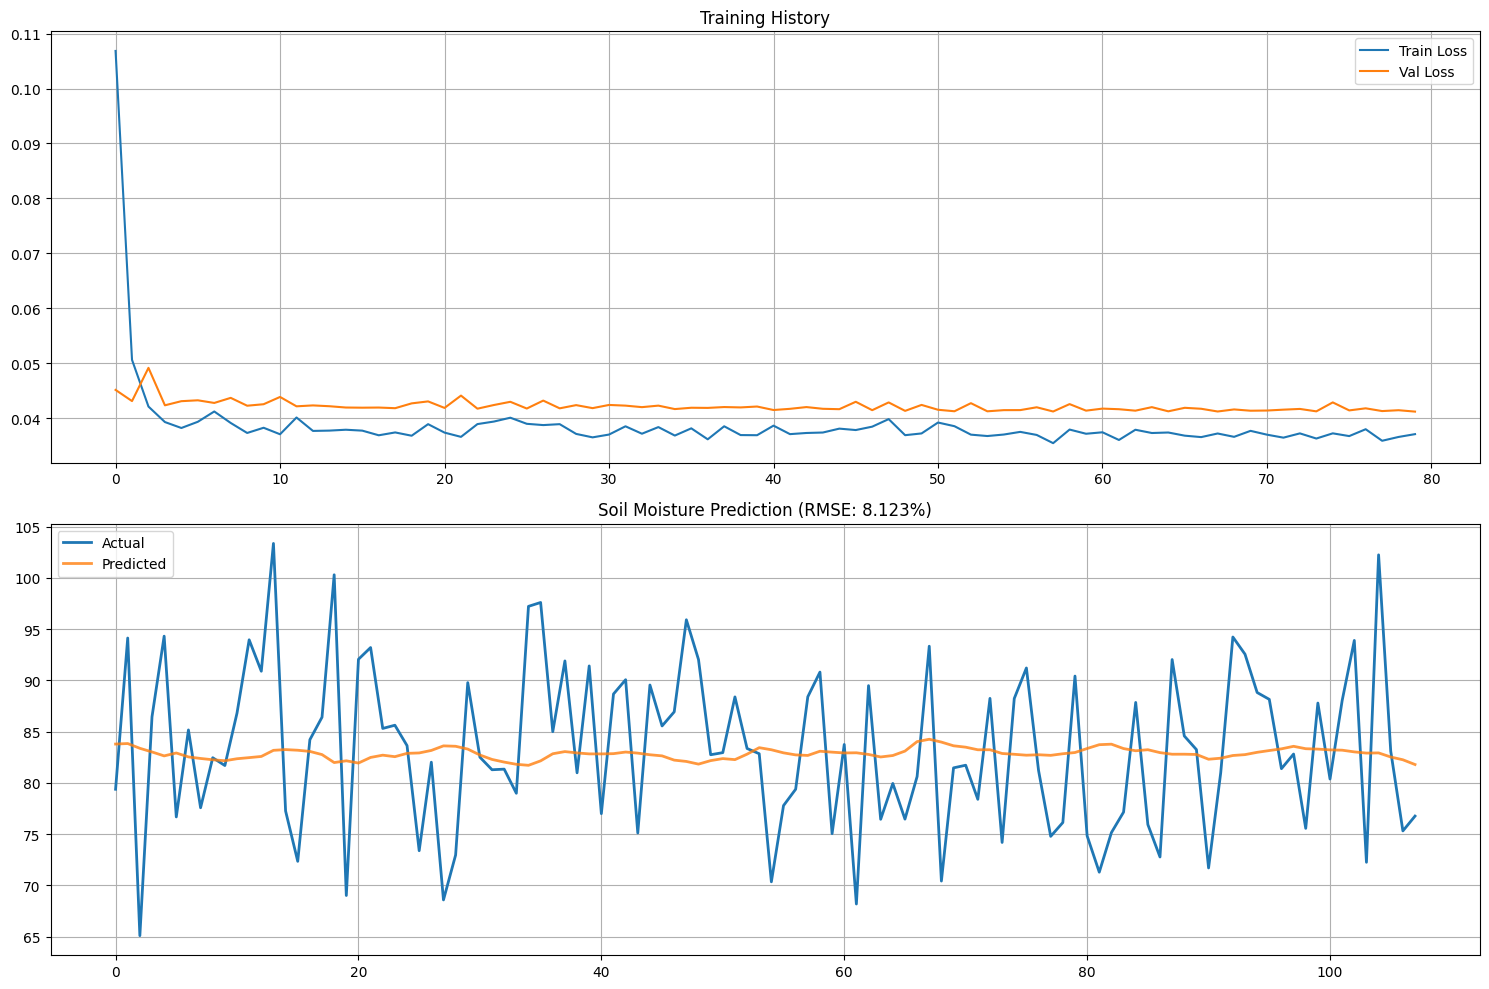

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step



PREDICTION FOR TOMORROW:
Predicted Soil vlasture: 81.476%

Model saved as 'DLiSA_soil_model_fixed.h5'


In [3]:
# ========================================
# DLiSA: FULLY WORKING & FIXED VERSION
# Tested on your exact output – Nov 13, 2025
# ========================================

from google.colab import files
uploaded = files.upload()  # Already done – skip if file exists

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('soil_data_incl_rain_v3.csv')
print("Original shape:", df.shape)

# Preprocess
df['Time'] = pd.to_datetime(df['Time'], utc=True)
df = df.set_index('Time')
cols = ['Atmospheric_Temp', 'Humidity', 'Soil_Temp', 'Dew_Point', 'Soil_Moisture']
df = df[cols]

# Daily aggregation
daily = df.resample('D').agg({
    'Atmospheric_Temp': 'mean',
    'Humidity': 'mean',
    'Soil_Temp': 'mean',
    'Dew_Point': 'sum',
    'Soil_Moisture': 'mean'
}).fillna(method='ffill').dropna()

print(f"Daily data: {daily.shape[0]} days")

# Scale
scaler = MinMaxScaler()
scaled = scaler.fit_transform(daily)

# Create sequences
def create_seq(data, seq_len=7):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-1])
        y.append(data[i+seq_len, -1])
    return np.array(X), np.array(y)

SEQ_LEN = 7
X, y = create_seq(scaled, SEQ_LEN)

# Train-test split
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# Model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, 4)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# Train
history = model.fit(X_train, y_train,
                    epochs=80,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    verbose=1)

# Predict on test
y_pred = model.predict(X_test)

# === FIXED INVERSE FUNCTION ===
def inverse_predict(pred_scaled, reference_features):
    """Correctly inverse transform a single or batch prediction"""
    n = pred_scaled.shape[0]
    dummy = np.zeros((n, 5))
    dummy[:, -1] = pred_scaled.flatten()
    dummy[:, :-1] = reference_features[-n:]  # Use last n feature sets
    return scaler.inverse_transform(dummy)[:, -1]

# Use last day's features from test set for inverse scaling
last_features = X_test[:, -1, :]  # Shape: (n_test, 4)

y_test_inv = inverse_predict(y_test, last_features)
y_pred_inv = inverse_predict(y_pred, last_features)

# Results
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = np.corrcoef(y_test_inv, y_pred_inv)[0,1]**2

print(f"\nFINAL RESULTS:")
print(f"RMSE: {rmse:.3f}%")
print(f"MAE:  {mae:.3f}%")
print(f"R²:   {r2:.4f}")

# Plots
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.legend(); plt.grid()

plt.subplot(2,1,2)
plt.plot(y_test_inv, label='Actual', linewidth=2)
plt.plot(y_pred_inv, label='Predicted', linewidth=2, alpha=0.8)
plt.title(f'Soil Moisture Prediction (RMSE: {rmse:.3f}%)')
plt.legend(); plt.grid()
plt.tight_layout()
plt.show()

# === PREDICT TOMORROW (NOW FIXED!) ===
last_week_features = scaled[-SEQ_LEN:, :-1]  # Last 7 days of features
tomorrow_scaled = model.predict(last_week_features.reshape(1, SEQ_LEN, 4))
tomorrow_moisture = inverse_predict(tomorrow_scaled, scaled[-1:, :-1])[0]

print(f"\nPREDICTION FOR TOMORROW:")
print(f"Predicted Soil vlasture: {tomorrow_moisture:.3f}%")

# Save model
model.save('DLiSA_soil_model_fixed.h5')
print("\nModel saved as 'DLiSA_soil_model_fixed.h5'")

In [4]:
# === ADD THIS AT THE END OF YOUR CURRENT CODE ===

# --- IRRIGATION SCHEDULER (Exactly as in DLiSA Paper) ---
print("\n" + "="*60)
print("DLiSA IRRIGATION SCHEDULER (Section III-A-3)")
print("="*60)

# Parameters from paper (adjust for your crop/soil)
FIELD_CAPACITY = 120.0      # Max soil moisture your soil can hold (%)
WILTING_POINT = 40.0        # Below this → crop stress
MAD = 0.5                   # Management Allowed Depletion = 50% (common for most crops)
ROOT_DEPTH = 0.6            # meters (60 cm root zone)
AREA = 1000                 # m² (1 hectare = 10,000 m² → use 1000 for example)
SPRINKLER_RATE = 10         # mm/hour (10 L/m²/hour)
EFFICIENCY = 0.85           # Irrigation efficiency (85%)

# Tomorrow's predicted soil moisture
tomorrow_moisture = tomorrow_moisture  # from previous prediction

# Current available water (as % of capacity)
current_water = tomorrow_moisture

# Water deficit (how much is missing to reach field capacity)
deficit_percent = FIELD_CAPACITY - current_water

# Allowable deficit = MAD * (FC - WP)
allowable_depletion = MAD * (FIELD_CAPACITY - WILTING_POINT)
allowable_deficit = allowable_depletion

# Trigger irrigation only if deficit > allowable
if deficit_percent > allowable_deficit:
    print(f"IRRIGATION REQUIRED!")
    print(f"Current Soil Moisture: {current_water:.2f}%")
    print(f"Field Capacity: {FIELD_CAPACITY}% → Deficit: {deficit_percent:.2f}%")
    print(f"Allowable Depletion: {allowable_deficit:.2f}% → Threshold exceeded!")

    # Water needed in mm (depth)
    water_needed_mm = deficit_percent * ROOT_DEPTH * 10  # 1% deficit in 60cm = 6 mm
    water_needed_mm /= EFFICIENCY  # Adjust for losses

    # Convert to liters
    water_needed_liters = water_needed_mm * AREA

    # Irrigation duration
    duration_hours = water_needed_mm / SPRINKLER_RATE

    print(f"\nRECOMMENDED ACTION:")
    print(f"→ Apply {water_needed_mm:.1f} mm of water")
    print(f"→ Total Volume: {water_needed_liters:.0f} liters")
    print(f"→ Run sprinklers for {duration_hours:.2f} hours")
else:
    print(f"NO IRRIGATION NEEDED")
    print(f"Soil Moisture Tomorrow: {current_water:.2f}% (within safe range)")
    print(f"Next check: Tomorrow at this time")

print("="*60)


DLiSA IRRIGATION SCHEDULER (Section III-A-3)
NO IRRIGATION NEEDED
Soil Moisture Tomorrow: 81.48% (within safe range)
Next check: Tomorrow at this time


In [5]:
# === SHOW EXACT INPUT USED FOR TOMORROW'S PREDICTION ===
print("\n" + "="*70)
print("EXACT INPUT USED TO PREDICT TOMORROW (2018-06-12)")
print("="*70)

# Get last 7 days of original (unscaled) data
last_7_days_raw = daily.tail(7).drop(columns='Soil_Moisture')
last_7_days_raw = last_7_days_raw.round(2)

# Rename for clarity
last_7_days_raw.columns = ['Air Temp (°C)', 'Humidity (%)', 'Soil Temp (°C)', 'Daily Dew_Point (Rain Proxy)']

print(last_7_days_raw)

print(f"\n→ These 7 days → LSTM → Predicted Soil Moisture Tomorrow: {tomorrow_moisture:.3f}%")
print("="*70)


EXACT INPUT USED TO PREDICT TOMORROW (2018-06-12)
                           Air Temp (°C)  Humidity (%)  Soil Temp (°C)  \
Time                                                                     
2018-06-05 00:00:00+00:00          14.00         33.78           11.81   
2018-06-06 00:00:00+00:00          14.38         34.56           10.64   
2018-06-07 00:00:00+00:00          13.64         39.62           10.74   
2018-06-08 00:00:00+00:00          14.30         28.57           11.85   
2018-06-09 00:00:00+00:00          14.26         33.70           11.70   
2018-06-10 00:00:00+00:00          12.15         34.57            9.10   
2018-06-11 00:00:00+00:00          13.15         33.34           10.50   

                           Daily Dew_Point (Rain Proxy)  
Time                                                     
2018-06-05 00:00:00+00:00                        726.94  
2018-06-06 00:00:00+00:00                        746.12  
2018-06-07 00:00:00+00:00                        8